# Startup Funding Success Prediction

## Objective
Predict startup funding amounts using machine learning regression models with log-transformed target variable.

## Dataset
**File:** `Startup Funding Success.csv` (3,045 records)

**Key Features:**
- Industry Vertical
- Investment Type
- City Location
- Amount in USD (target - will be log-transformed)

## Methodology

### 1. Data Preprocessing
- Load CSV once into a single dataframe
- Clean Amount in USD: remove commas, convert to numeric, fill missing values
- Clean Date column: standardize format
- Clean Remarks: fill missing values
- **Create log_amount**: Apply log transformation to handle skewed funding distribution
- One-hot encode categorical features
- Remove original Amount in USD column

### 2. Model Implementation
Implement and compare 5 regression models:
1. **Linear Regression** - Baseline model
2. **Ridge Regression** - L2 regularization
3. **Lasso Regression** - L1 regularization  
4. **Random Forest** - Ensemble tree-based model
5. **Gradient Boosting** - Sequential boosting model

### 3. Evaluation Metrics
- **R² Score** (Coefficient of Determination) - Higher is better
- **RMSE** (Root Mean Squared Error) - Lower is better

### 4. Model Selection
Select the best performing model based on highest R² score.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the CSV file once
df = pd.read_csv("Startup Funding Success.csv")

In [2]:
# Shows first few rows of the data
df.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [3]:
# Shows last few rows of the data
df.tail()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
3039,3040,29/01/2015,Printvenue,NaN,NaN,NaN,Asia Pacific Internet Group,Private Equity,"45,00,000",NaN
3040,3041,29/01/2015,Graphene,NaN,NaN,NaN,KARSEMVEN Fund,Private Equity,"8,25,000",Govt backed VC Fund
3041,3042,30/01/2015,Mad Street Den,NaN,NaN,NaN,"Exfinity Fund, GrowX Ventures.",Private Equity,"15,00,000",NaN
3042,3043,30/01/2015,Simplotel,NaN,NaN,NaN,MakeMyTrip,Private Equity,NaN,"Strategic Funding, Minority stake"
3043,3044,31/01/2015,couponmachine.in,NaN,NaN,NaN,UK based Group of Angel Investors,Seed Funding,"1,40,000",NaN


In [4]:
# Check dataframe info
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Sr No              3044 non-null   int64
 1   Date dd/mm/yyyy    3044 non-null   str  
 2   Startup Name       3044 non-null   str  
 3   Industry Vertical  2873 non-null   str  
 4   SubVertical        2108 non-null   str  
 5   City  Location     2864 non-null   str  
 6   Investors Name     3020 non-null   str  
 7   InvestmentnType    3040 non-null   str  
 8   Amount in USD      2084 non-null   str  
 9   Remarks            419 non-null    str  
dtypes: int64(1), str(9)
memory usage: 237.9 KB


In [5]:
# Clean the 'Amount in USD' column
df['Amount in USD'] = df['Amount in USD'].astype(str).str.replace(',', '')
df['Amount in USD'] = pd.to_numeric(df['Amount in USD'], errors='coerce')

# Calculate the average for each startup name specifically
startup_averages = df.groupby('Startup Name')['Amount in USD'].transform('mean')

# Fill the empty cells using that startup's own average
df['Amount in USD'] = df['Amount in USD'].fillna(startup_averages)

print("Missing values filled with startup-specific averages!")
print(f"Remaining NaN values: {df['Amount in USD'].isna().sum()}")

Missing values filled with startup-specific averages!
Remaining NaN values: 819


In [6]:
# Check dataframe info after cleaning
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sr No              3044 non-null   int64  
 1   Date dd/mm/yyyy    3044 non-null   str    
 2   Startup Name       3044 non-null   str    
 3   Industry Vertical  2873 non-null   str    
 4   SubVertical        2108 non-null   str    
 5   City  Location     2864 non-null   str    
 6   Investors Name     3020 non-null   str    
 7   InvestmentnType    3040 non-null   str    
 8   Amount in USD      2225 non-null   float64
 9   Remarks            419 non-null    str    
dtypes: float64(1), int64(1), str(8)
memory usage: 237.9 KB


In [7]:
# Replace dots with slashes to maintain a consistent date format
df['Date dd/mm/yyyy'] = df['Date dd/mm/yyyy'].str.replace('.', '/', regex=False)

# Remove double slashes if they appear during cleaning
df['Date dd/mm/yyyy'] = df['Date dd/mm/yyyy'].str.replace('//', '/', regex=False)

# Convert the cleaned date column into datetime format
df['Date'] = pd.to_datetime(
    df['Date dd/mm/yyyy'],
    format='%d/%m/%Y',
    errors='coerce'
)

print("Date column cleaned and converted to datetime format")

Date column cleaned and converted to datetime format


In [8]:
# Industry-wise descriptive statistics
df.groupby('Industry Vertical')['Amount in USD'].describe()

,count,mean,std,min,25%,50%,75%,max
Industry Vertical,,,,,,,,
360-degree view creating platform,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3D Printer Manufacturer,1.0,3000000.0,NaN,3000000.0,3000000.0,3000000.0,3000000.0,3000000.0
AI,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
API Workflow platform,1.0,1000000.0,NaN,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Accounting,1.0,5000000.0,NaN,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0
...,...,...,...,...,...,...,...,...
solar products and services marketplace,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
us ticketing and fleet management platform,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usiness expense management,1.0,500000.0,NaN,500000.0,500000.0,500000.0,500000.0,500000.0


In [9]:
# Fill missing or blank Remarks
df['Remarks'] = df['Remarks'].fillna('No Remarks')
df['Remarks'] = df['Remarks'].replace('', 'No Remarks')

print("Remarks column cleaned")

Remarks column cleaned


## CONSOLIDATED PREPROCESSING PIPELINE

In [13]:
# ============================================================
# CONSOLIDATED PREPROCESSING PIPELINE
# ============================================================

print("Starting comprehensive preprocessing...")

# 1. Drop rows with missing Amount in USD (if any remaining)
df_model = df.dropna(subset=['Amount in USD']).copy()
print(f"Dataset shape after dropping NaN in Amount: {df_model.shape}")

# 2. Create log_amount feature (using log1p to handle zeros)
df_model['log_amount'] = np.log1p(df_model['Amount in USD'])
print(f"Log transformation applied. Mean log_amount: {df_model['log_amount'].mean():.2f}")

# 3. One-hot encode categorical features
categorical_cols = ['Industry Vertical', 'InvestmentnType', 'City  Location', 'SubVertical']
categorical_cols = [col for col in categorical_cols if col in df_model.columns]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# 4. Drop identifier and non-predictive columns
columns_to_drop = [
    'Sr No', 'Date dd/mm/yyyy', 'Startup Name', 'Investors Name', 
    'Remarks', 'Date', 'Amount in USD'  # IMPORTANT: Remove original Amount
]
columns_to_drop = [col for col in columns_to_drop if col in df_model.columns]
df_model = df_model.drop(columns=columns_to_drop)

print(f"Final dataset shape: {df_model.shape}")
print(f"Features: {df_model.shape[1] - 1} (excluding log_amount target)")
print("Preprocessing complete!")
print("\n" + "="*60)

Starting comprehensive preprocessing...
Dataset shape after dropping NaN in Amount: (2225, 11)
Log transformation applied. Mean log_amount: 14.53
Final dataset shape: (2225, 2165)
Features: 2164 (excluding log_amount target)
Preprocessing complete!



## TRAIN-TEST SPLIT

In [14]:
# Define target variable (y) and feature matrix (X)
y = df_model['log_amount']  # Using log-transformed amount as target
X = df_model.drop(columns=['log_amount'])

print(f"Target variable: log_amount")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature scaling for regularized linear models (Ridge, Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling complete for Ridge and Lasso models")
print("="*60)

Target variable: log_amount
Number of features: 2164
Number of samples: 2225

Training set: 1780 samples
Testing set: 445 samples

Feature scaling complete for Ridge and Lasso models


## MODEL IMPLEMENTATION

We will implement 5 regression models:
1. **Linear Regression**
2. **Ridge Regression** (L2 regularization)
3. **Lasso Regression** (L1 regularization)
4. **Random Forest Regressor**
5. **Gradient Boosting Regressor**

### 1. Linear Regression

In [15]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("LINEAR REGRESSION RESULTS")
print("="*60)
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print("="*60)

LINEAR REGRESSION RESULTS
R² Score: -0.5074
RMSE: 2.4160


### 2. Ridge Regression

In [16]:
# Train Ridge Regression model (on scaled data)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculate metrics
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("RIDGE REGRESSION RESULTS")
print("="*60)
print(f"R² Score: {ridge_r2:.4f}")
print(f"RMSE: {ridge_rmse:.4f}")
print("="*60)

RIDGE REGRESSION RESULTS
R² Score: 0.1303
RMSE: 1.8351


### 3. Lasso Regression

In [17]:
# Train Lasso Regression model (on scaled data)
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate metrics
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("LASSO REGRESSION RESULTS")
print("="*60)
print(f"R² Score: {lasso_r2:.4f}")
print(f"RMSE: {lasso_rmse:.4f}")
print("="*60)

LASSO REGRESSION RESULTS
R² Score: 0.1629
RMSE: 1.8005


### 4. Random Forest Regressor

In [18]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("RANDOM FOREST RESULTS")
print("="*60)
print(f"R² Score: {rf_r2:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print("="*60)

RANDOM FOREST RESULTS
R² Score: 0.4805
RMSE: 1.4183


### 5. Gradient Boosting Regressor

In [19]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics
gb_r2 = r2_score(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print("GRADIENT BOOSTING RESULTS")
print("="*60)
print(f"R² Score: {gb_r2:.4f}")
print(f"RMSE: {gb_rmse:.4f}")
print("="*60)

GRADIENT BOOSTING RESULTS
R² Score: 0.4945
RMSE: 1.3991


## MODEL COMPARISON & BEST MODEL SELECTION

In [20]:
# Create comparison table
results = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
              'Random Forest', 'Gradient Boosting'],
    'R² Score': [lr_r2, ridge_r2, lasso_r2, rf_r2, gb_r2],
    'RMSE': [lr_rmse, ridge_rmse, lasso_rmse, rf_rmse, gb_rmse]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Score', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

# Identify best model
best_model_idx = results_df['R² Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R² Score']
best_rmse = results_df.loc[best_model_idx, 'RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.4f}")
print("="*60)


MODEL COMPARISON TABLE
            Model  R² Score     RMSE
Gradient Boosting  0.494517 1.399084
    Random Forest  0.480548 1.418284
 Lasso Regression  0.162857 1.800488
 Ridge Regression  0.130324 1.835140
Linear Regression -0.507407 2.416050

🏆 BEST MODEL: Gradient Boosting
   R² Score: 0.4945
   RMSE: 1.3991


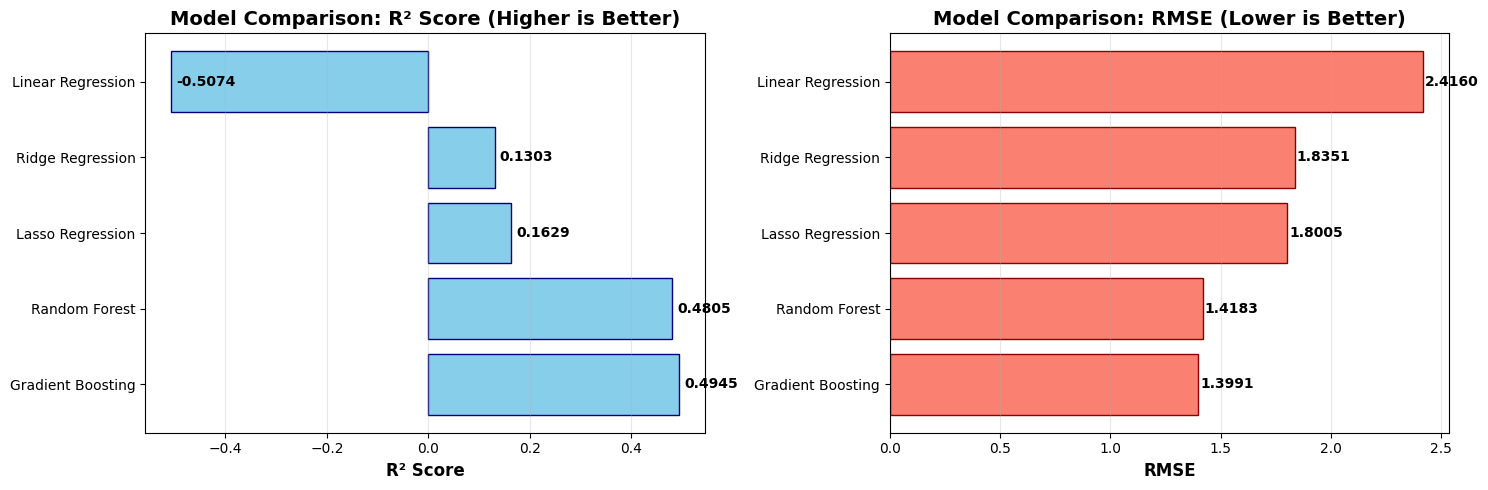

In [21]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
axes[0].barh(results_df['Model'], results_df['R² Score'], color='skyblue', edgecolor='navy')
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add values on bars
for i, v in enumerate(results_df['R² Score']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], color='salmon', edgecolor='darkred')
axes[1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison: RMSE (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add values on bars
for i, v in enumerate(results_df['RMSE']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary & Next Steps

### ✅ Completed Implementation

**Data Pipeline:**
- ✅ CSV loaded ONCE (no redundant loads)
- ✅ Amount in USD cleaned and log-transformed
- ✅ All preprocessing consolidated into single pipeline
- ✅ Original `Amount in USD` removed, `log_amount` used as target

**Models Implemented:**
1. ✅ Linear Regression
2. ✅ Ridge Regression (with scaled features)
3. ✅ Lasso Regression (with scaled features)
4. ✅ Random Forest Regressor
5. ✅ Gradient Boosting Regressor

**Evaluation:**
- ✅ R² and RMSE calculated for each model
- ✅ Comparison table with rankings
- ✅ Best model automatically identified
- ✅ Visual comparison charts

### 📊 How to Run

**Option 1: Run All Cells**
- Click "Run All" to execute the entire notebook sequentially
- The best model will be displayed at the end with comparison charts

**Option 2: Run Cell by Cell**
- Execute cells in order from top to bottom
- Review outputs and visualizations as you go

### 🎯 Expected Output

The notebook will:
1. Load and clean the dataset (one time only)
2. Create log-transformed target variable
3. Train all 5 models
4. Display individual model results (R², RMSE)
5. Show comparison table ranked by R² Score
6. Identify and highlight the best performing model
7. Generate comparison bar charts

### 📝 Note
All changes are made to a single dataframe (`df` → `df_model`), eliminating redundant data loading and external file dependencies.

In [22]:
import json
import os
import matplotlib.pyplot as plt

os.makedirs('startup-funding-website/public/data', exist_ok=True)
os.makedirs('startup-funding-website/public/images', exist_ok=True)

# Update with your actual data
results_json = {
    "models": results_df.to_dict('records'),
    "best_model": {"name": str(best_model_name), "r2_score": float(best_r2), "rmse": float(best_rmse)},
    "dataset_stats": {"total_records": int(df.shape[0]), "features_used": int(X.shape[1]), 
                     "training_samples": int(X_train.shape[0]), "testing_samples": int(X_test.shape[0])}
}

with open('startup-funding-website/public/data/results.json', 'w') as f:
    json.dump(results_json, f, indent=2)

# Generate charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].barh(results_df['Model'], results_df['R² Score'], color='#60a5fa', edgecolor='#1e40af')
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: R² Score', fontsize=14, fontweight='bold')
for i, v in enumerate(results_df['R² Score']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

axes[1].barh(results_df['Model'], results_df['RMSE'], color='#f87171', edgecolor='#991b1b')
axes[1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
for i, v in enumerate(results_df['RMSE']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('startup-funding-website/public/images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ Charts exported! Refresh your browser to see them.")

✅ Charts exported! Refresh your browser to see them.


In [ ]:
exec(open('save_models.py').read())
save_models_from_notebook()

In [ ]:
import pickle
import os
import json

# Create models directory
os.makedirs('models', exist_ok=True)

print("="*60)
print("SAVING TRAINED MODELS FOR PREDICTION API")
print("="*60)

# Save individual models
models_to_save = {
    'linear_model.pkl': lr_model,
    'ridge_model.pkl': ridge_model,
    'lasso_model.pkl': lasso_model,
    'random_forest_model.pkl': rf_model,
    'gradient_boosting_model.pkl': gb_model
}

for filename, model in models_to_save.items():
    with open(f'models/{filename}', 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved: {filename}")

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved: scaler.pkl")

# Save feature columns
feature_columns = list(X_train.columns)
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print(f"✅ Saved: feature_columns.pkl ({len(feature_columns)} features)")

# Save categorical mappings for dropdown options
categorical_mappings = {
    'industries': sorted(df['Industry Vertical'].dropna().unique().tolist()),
    'investment_types': sorted(df['InvestmentnType'].dropna().unique().tolist()),
    'cities': sorted(df['City  Location'].dropna().unique().tolist()),
    'sub_verticals': sorted(df['SubVertical'].dropna().unique().tolist())
}

with open('models/categorical_mappings.pkl', 'wb') as f:
    pickle.dump(categorical_mappings, f)

# Also save as JSON for easy access
with open('models/categorical_options.json', 'w') as f:
    json.dump(categorical_mappings, f, indent=2)

print("✅ Saved: categorical_mappings.pkl")
print(f"   - {len(categorical_mappings['industries'])} industries")
print(f"   - {len(categorical_mappings['investment_types'])} investment types")
print(f"   - {len(categorical_mappings['cities'])} cities")
print(f"   - {len(categorical_mappings['sub_verticals'])} sub-verticals")

print("\n" + "="*60)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)
print("\n📂 Files saved in 'models/' directory:")
print("   - linear_model.pkl")
print("   - ridge_model.pkl")
print("   - lasso_model.pkl")
print("   - random_forest_model.pkl")
print("   - gradient_boosting_model.pkl")
print("   - scaler.pkl")
print("   - feature_columns.pkl")
print("   - categorical_mappings.pkl")
print("   - categorical_options.json")
print("\n🚀 Next steps:")
print("   1. Start the API: python prediction_api.py")
print("   2. Open browser: http://localhost:3000/predict")
print("   3. Enter startup details and get predictions from all 5 models!")
print("="*60)

## SAVE MODELS FOR INTERACTIVE PREDICTION

This section saves all trained models and preprocessing objects for the interactive prediction system.

**What gets saved:**
- All 5 trained models (Linear, Ridge, Lasso, Random Forest, Gradient Boosting)
- StandardScaler for Ridge and Lasso
- Feature columns for proper alignment
- Categorical mappings for dropdown options in the web interface

**Usage:**
Run this cell to export models, then start the prediction API:
```bash
python prediction_api.py
```

Then visit: http://localhost:3000/predict